# **CUHK-STAT3009**: Homework 3 - Neural Network in RS: Models, Algorithm, and virtualization (**due Dec 04**)

## **Q1: Data preprocessing**

In [ ]:
## use iris dataset in Q1
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
data = load_iris(as_frame=True)

### **Q1.1**
- Standardize features by removing the mean and scaling to unit variance.
- Merge `data.data` and `data.target` as a one `dataframe` with columns: [`sepal length (cm)`,	`sepal width (cm)`, `petal length (cm)`, `petal width (cm)`, `target`]
- Compute the target-specific mean of each features, that is,

              sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
      target
      0                   5.006             3.428              1.462             0.246
      1                   5.936             2.770              4.260             1.326
      2                   6.588             2.974              5.552             2.026

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
data = load_iris(as_frame=True)
X = data.data
y = data.target

scaler = StandardScaler()
X_ans = scaler.fit_transform(X)
X_ans = pd.DataFrame(X_ans, columns=X.columns)

iris_df = data.data.copy()
iris_df["target"] = y

target_mean = iris_df.groupby("target").mean()
target_mean

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
0,5.006,3.428,1.462,0.246
1,5.936,2.770,4.260,1.326
2,6.588,2.974,5.552,2.026


### **Q1.2**

- Using `seaborn` to show the `Violinplot` of all features against `target`
- Using `seaborn` to show the `heatmap` of the correlation between all features

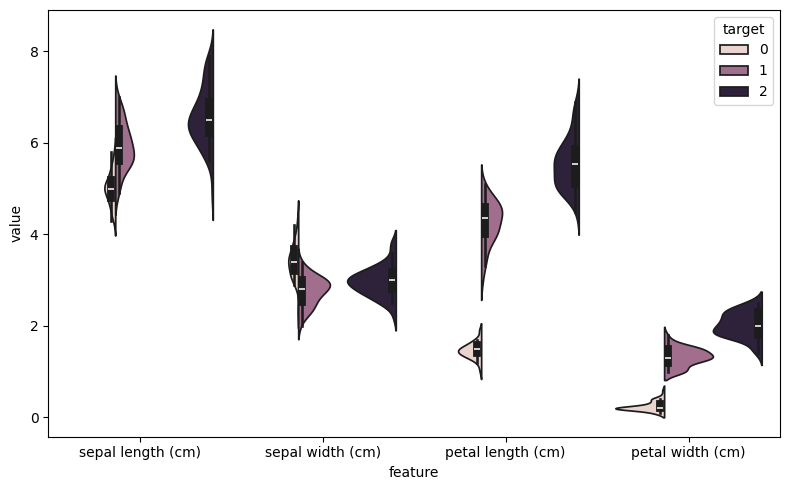

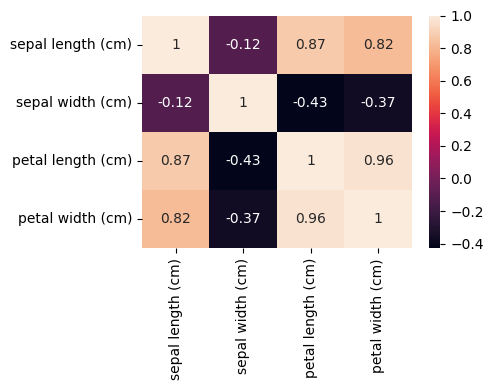

In [ ]:
## Your solution to Q1.2 here
import seaborn as sns
import matplotlib.pyplot as plt

iris_df = data.data.copy()
iris_df["target"] = data.target

long_df = iris_df.melt(id_vars="target", var_name="feature", value_name="value")

plt.figure(figsize=(8, 5))
sns.violinplot(data=long_df, x="feature", y="value", hue="target", split=True)
plt.tight_layout()
plt.show()

corr = iris_df.drop(columns="target").corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True)
plt.tight_layout()
plt.show()


## **Q2. Semi-parametric model**

A semi-parametric model is widely used in statistical learning, machine learning, and deep learning. Given a feature-vector $\mathbf{x}$, the outcome is formulated as:
$$
f(\mathbf{x}) = \mathbf{\beta}^\intercal \mathbf{x} + h(\mathbf{x}),
$$
where $\mathbf{\beta}$ is a linear coefficient, and $h(\cdot)$ is a nonlinear function. In this question, you are expected to use $f(\mathbf{x})$ to make prediction in `California Housing dataset` based on `tensorflow`

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### **Q2.1**

- Standardize features of by removing the mean and scaling to unit variance.
- Using `tensorflow` build up a network for the model $f(\mathbf{x})$ with $h(\mathbf{x})$ as two `Dense` layers: `Dense(8, activation='relu')` + `Dense(1, activation='linear')`
- Print `model.summary()` for your model

In [ ]:
## Your solution to Q2.1 here
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.layers import Dense

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

class SemiParametric(keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(units=1)
        self.dense2 = Dense(units=8, activation='relu')
        self.dense3 = Dense(units=1)

    def call(self, inputs):
        lin = self.dense1(inputs)
        h = self.dense2(inputs)
        h = self.dense3(h)
        return lin + h

model = SemiParametric()
dummy = keras.backend.zeros((1, X_train_std.shape[1]))
model(dummy)

model.summary()


Model: "semi_parametric"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (1, 1)                 │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 8)                 │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 1)                 │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90 (360.00 B)

 Trainable params: 90 (360.00 B)

 Non-trainable params: 0 (0.00 B)

### **Q2.2**

- Compile the model with `loss`: [MAE](https://keras.io/api/losses/regression_losses/#meanabsoluteerror-class); `optimizer`: [SGD](https://keras.io/api/optimizers/sgd/); and monitoring `Metrics`: `RMSE`

- fit model
  - using `X_train`, `y_train`
  - taking 20% of data as validation set
  - [earlystopping](https://keras.io/api/callbacks/) based on `RMSE` on `validation set` with custom `patience` and other hyperparamters

- Make prediction to `X_test`, and evaluate the prediction by reporting `RMSE` and `MAE`.

In [ ]:
## Your solution to Q2.2 here
from tensorflow import keras

opt = keras.optimizers.SGD(1e-4)

model.compile(optimizer=opt,
              loss='mean_absolute_error',
              metrics=['root_mean_squared_error'])

es = keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                   patience=10,
                                   restore_best_weights=True)

history = model.fit(X_train_std,
                    y_train,
                    batch_size=64,
                    epochs=200,
                    validation_split=0.2,
                    callbacks=[es],
                    verbose=0)

test_mae, test_rmse = model.evaluate(X_test_std, y_test, verbose=0)
print("Test MAE:", test_mae)
print("Test RMSE:", test_rmse)


Test MAE: 0.5896264314651489
Test RMSE: 0.820688009262085


## **Q3: Implementing a Custom Recommender System using TensorFlow**

**Recommender System Model:**

The goal of this question is to implement a custom recommender system model using TensorFlow. The model is defined as follows:

$$\widehat{r}_{ui} = \mathbf{p}_u^\intercal \mathbf{q}_i + b_i + \mathbf{p}_u^\intercal \mathbf{p}_u + a_u$$

where:

* $\widehat{r}_{ui}$ is the predicted rating for user $u$ and item $i$
* $\mathbf{p}_u$ is the user latent factor vector
* $\mathbf{q}_i$ is the item latent factor vector
* $b_i$ is the item bias term
* $a_u$ is the user bias term

**Your Task:**

Implement this model using TensorFlow on our course dataset. You will need to:

1. Load the dataset and preprocess the data as needed
2. Define the model architecture using TensorFlow
3. Implement the loss function and optimizer
4. Train the model on the dataset
5. Evaluate the performance of the model using a `Acc`.

**Note:** You can use TensorFlow's built-in functions and modules to implement the model. Note that the prediction result is not of importance; this question only assesses your implementation.

In [ ]:
import numpy as np

def Acc(true_rating, pred_rating):
  return np.mean(true_rating == pred_rating)

In [ ]:
## Dowload binary dataset in CUHK-STAT3009 Github repo
import pandas as pd

train_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/b-rs/train.csv"
test_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/b-rs/test.csv"

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

y_train = np.array(train['rating'].values, dtype=float)
X_train = train[['user_id', 'movie_id']].values

y_test = np.array(test['rating'].values, dtype=float)
X_test = test[['user_id', 'movie_id']].values

n_user = max( max(X_train[:,0]), max(X_test[:,0]) ) + 1
n_item = max( max(X_train[:,1]), max(X_test[:,1]) ) + 1

In [ ]:
## Your solution to Q3 here
import numpy as np

def Acc(true_rating, pred_rating):
  return np.mean(true_rating == pred_rating)

import pandas as pd

train_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/b-rs/train.csv"
test_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/b-rs/test.csv"

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

y_train = np.array(train['rating'].values, dtype=float)
X_train = train[['user_id', 'movie_id']].values

y_test = np.array(test['rating'].values, dtype=float)
X_test = test[['user_id', 'movie_id']].values

n_user = max( max(X_train[:,0]), max(X_test[:,0]) ) + 1
n_item = max( max(X_train[:,1]), max(X_test[:,1]) ) + 1

from tensorflow import keras
from keras import layers

class MyRS(keras.Model):
  def __init__(self, num_user, num_item, K=10):
    super().__init__()
    self.user_embed = layers.Embedding(input_dim=num_user, output_dim=K)
    self.item_embed = layers.Embedding(input_dim=num_item, output_dim=K)
    self.user_bias = layers.Embedding(input_dim=num_user, output_dim=1)
    self.item_bias = layers.Embedding(input_dim=num_item, output_dim=1)
    self.gamma = layers.Dense(1, use_bias=False)
    self.dot = layers.Dot(axes=1)

  def call(self, inputs):
    u = inputs[:, 0]
    i = inputs[:, 1]

    p_u = self.user_embed(u)
    q_i = self.item_embed(i)
    out_mf = self.dot([p_u, q_i])

    a_u = self.user_bias(u)
    b_i = self.item_bias(i)
    gamma_pu = self.gamma(p_u)

    return out_mf + b_i + gamma_pu + a_u

model = MyRS(n_user, n_item)

opt = keras.optimizers.Adam(1e-3)

model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['root_mean_squared_error'])

callback = [keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True,
)]

model.fit(x=X_train,
          y=y_train,
          epochs=20,
          batch_size=512,
          validation_split=0.3,
          callbacks=callback)

pred_test = model.predict(X_test).flatten()
pred_test_round = np.round(pred_test)
test_acc = Acc(y_test, pred_test_round)
print("Test Accuracy:", test_acc)


Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.5237 - root_mean_squared_error: 0.7233 - val_loss: 0.3607 - val_root_mean_squared_error: 0.6006
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3225 - root_mean_squared_error: 0.5676 - val_loss: 0.2543 - val_root_mean_squared_error: 0.5043
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2317 - root_mean_squared_error: 0.4814 - val_loss: 0.2260 - val_root_mean_squared_error: 0.4754
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2062 - root_mean_squared_error: 0.4541 - val_loss: 0.2172 - val_root_mean_squared_error: 0.4661
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1955 - root_mean_squared_error: 0.4421 - val_loss: 0.2132 - val_root_mean_squared_error: 0.4617
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1886 - root_mean_squared_error: 0.4343 - val_loss: 0.2110 - val_root_mean_squared_error: 0.4594
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss